# Macro UPI Transaction Trends  
## Daily System-Level Analysis

## Objective

This notebook performs a **system-level, high-resolution daily analysis** of India’s digital payment ecosystem, with **UPI as the focal instrument**.

The goal is not merely to show growth, but to answer deeper structural questions:

- Is UPI growth **organic and persistent**, or driven by short-term spikes?
- Do UPI anomalies indicate **system-wide stress**, or **instrument-specific issues**?
- How does UPI interact with other digital instruments during stress periods?
- Is the digital payments ecosystem becoming **more concentrated or more resilient** over time?

To answer these, we analyze:
- Daily transaction volumes
- Growth, volatility, and trend stability
- Instrument dominance and concentration
- Anomaly persistence
- Cross-instrument substitution behavior

This notebook establishes the **system baseline** that later notebooks build upon.

---

## Key Questions Addressed

1. **Is UPI driving overall digital transaction growth, or merely following it?**
2. **Are observed UPI anomalies signs of systemic failure or localized stress?**
3. **Does the ecosystem exhibit substitution when UPI underperforms?**
4. **Is growth maturing into stability or increasing volatility?**
5. **How concentrated is the digital payments ecosystem over time?**

All conclusions are derived using:
- Rolling statistics
- STL decomposition
- Z-score–based anomaly detection
- Growth and volatility diagnostics
- Cross-instrument comparative analysis

This notebook intentionally avoids assumptions and lets the data define the system behavior.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import STL

plt.style.use('seaborn-v0_8')

In [3]:
DATA_PATH = "/content/drive/MyDrive/Hotfoot/data/Daily_Usage.csv"

df_daily = pd.read_csv(DATA_PATH)
df_daily.head()

,date,RTGS_Vol,RTGS_Val,NEFT_Vol,NEFT_Val,AePS_Vol,AePS_Val,UPI_Vol,UPI_Val,IMPS_Vol,...,Credit Card_at e-Commerce_Vol,Credit Card_at e-Commerce_Val,Debit Card_at PoS_Vol,Debit Card_at PoS_Val,Debit Card_at e-Commerce_Vol,Debit Card_at e-Commerce_Val,Prepaid Payment Instruments (PPIs) Card_at PoS_Vol,Prepaid Payment Instruments (PPIs) Card_at PoS_Val,Prepaid Payment Instruments (PPIs) Card_at e-Commerce_Vol,Prepaid Payment Instruments (PPIs) Card_at e-Commerce_Val
0,2020-06-01,4.85,436996.69,172.11000,104275.130000,0.43618,7.682205,476.96710,10413.108975,76.80648,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-06-02,4.5434,361878.87153189996,100.06772,65259.016108,0.44138,7.665516,476.78182,9951.298586,72.24891,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-06-03,4.30157,330632.89225813,100.36426,62985.750191,0.43952,7.476038,456.25930,9622.375213,68.14805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-06-04,4.35152,329072.447410464,94.65655,63148.288625,0.44828,7.323838,463.04959,9639.502869,70.68543,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-06-05,4.56267,365468.95198416803,111.26259,68932.718600,0.47535,7.324794,464.79398,9539.524729,72.99507,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Dataset Overview

The daily usage dataset contains **date-wise transaction volumes and values** across multiple digital payment instruments in India.

Each row represents one calendar day, with columns capturing:
- Transaction volume (count)
- Transaction value (amount)
- Payment instruments such as UPI, IMPS, NEFT, RTGS, AePS, etc.

This dataset enables analysis of:
- System-wide growth trends
- Multi-seasonality patterns
- Sudden spikes or drops in usage
- Cross-instrument comparison to validate anomalies

In [4]:
df_daily['date'] = pd.to_datetime(df_daily['date'])
df_daily = df_daily.sort_values('date').reset_index(drop=True)

df_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2030 entries, 0 to 2029
Data columns (total 50 columns):
 #   Column                                                               Non-Null Count  Dtype         
---  ------                                                               --------------  -----         
 0   date                                                                 2030 non-null   datetime64[ns]
 1   RTGS_Vol                                                             2030 non-null   object        
 2   RTGS_Val                                                             2030 non-null   object        
 3   NEFT_Vol                                                             2030 non-null   float64       
 4   NEFT_Val                                                             2030 non-null   float64       
 5   AePS_Vol                                                             2030 non-null   float64       
 6   AePS_Val                                        

## Data Sanity Checks

Before modeling trends or detecting anomalies, it is critical to ensure:

- Dates are continuous and correctly ordered
- No artificial gaps exist that could produce false anomalies
- Missing or zero-value days are identified early

This step helps distinguish genuine behavioral anomalies from data-quality artefacts.

In [5]:
# Check missing dates
expected_dates = pd.date_range(df_daily['date'].min(), df_daily['date'].max())
missing_dates = expected_dates.difference(df_daily['date'])

print(f"Missing dates: {len(missing_dates)}")

Missing dates: 0


In [6]:
# --- GLOBAL VARIABLE DEFINITIONS ---
# Defining the instruments and calculated columns needed for the entire notebook
instrument_cols = [c for c in df_daily.columns if c.endswith('_Vol')]

# Ensure numeric types for these columns
for col in instrument_cols:
    df_daily[col] = pd.to_numeric(df_daily[col], errors='coerce').fillna(0)

# Total Digital Volume calculation
df_daily['TOTAL_DIGITAL_VOL'] = df_daily[instrument_cols].sum(axis=1)
df_daily['UPI_SHARE'] = df_daily['UPI_Vol'] / df_daily['TOTAL_DIGITAL_VOL']

print('Success: Global variables and instrument columns defined.')

Success: Global variables and instrument columns defined.


# Part 1: Establishing the Landscape
### Why this analysis?
Before diving into complex math, we must understand the 'gravity' of the ecosystem. We compute **Market Share Heatmaps** to see if UPI is an outlier or if the whole system is rising together. This tells us if a failure in UPI would be a minor glitch or a national emergency.

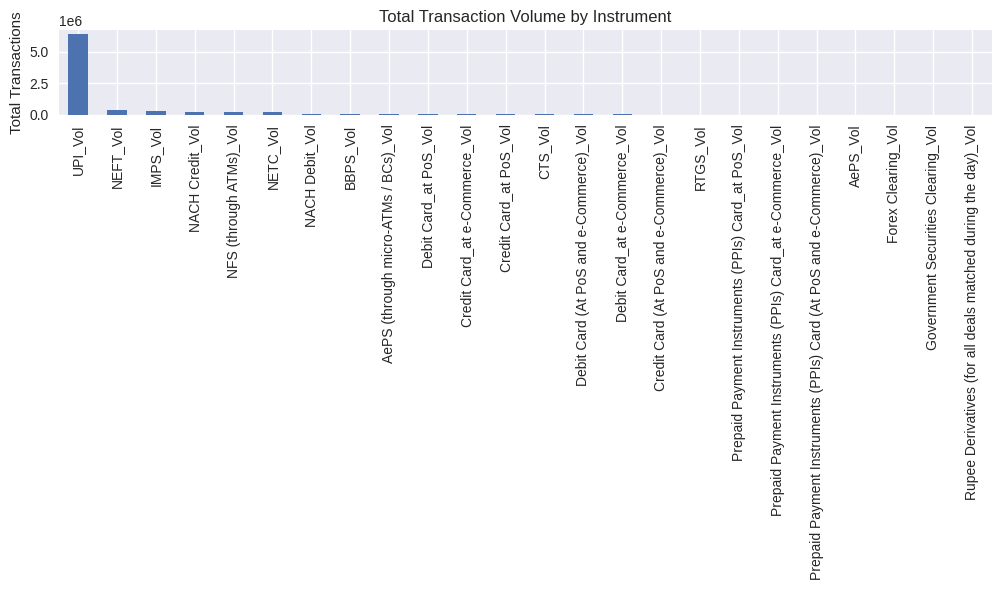

In [7]:
instrument_volume_totals = (
    df_daily[instrument_cols]
    .sum()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10,6))
instrument_volume_totals.plot(kind='bar')
plt.title("Total Transaction Volume by Instrument")
plt.ylabel("Total Transactions")
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/Hotfoot/figures/nb1_fig_01_instrument_dominance.png")
plt.show()

## Total Transaction Volume by Instrument

### Why this step?
Before analyzing UPI risk or anomalies, we establish which instruments
actually carry the bulk of system transaction volume.

This provides context for interpreting:
- UPI dominance
- Substitution capacity
- System-level risk concentration

### What we observe
- UPI accounts for the majority of total digital transaction volume
- All other instruments form a long tail with much smaller contributions
- Non-UPI instruments serve specialized or complementary roles

### Why this matters
- System-wide volume trends are largely UPI-driven
- UPI stability is critical for overall system stability
- Substitution potential exists, but at smaller absolute scales

### Key takeaway
UPI functions as the **structural backbone** of the digital payments ecosystem,
making it the primary focus for system-level monitoring and risk assessment.

## Monthly Usage Intensity by Instrument

### Why this analysis?
Before interpreting monthly anomalies or growth shifts, we check whether
digital payment instruments exhibit **seasonal usage patterns**.

If strong seasonality exists, some monthly fluctuations may be normal
calendar effects rather than system-level signals.

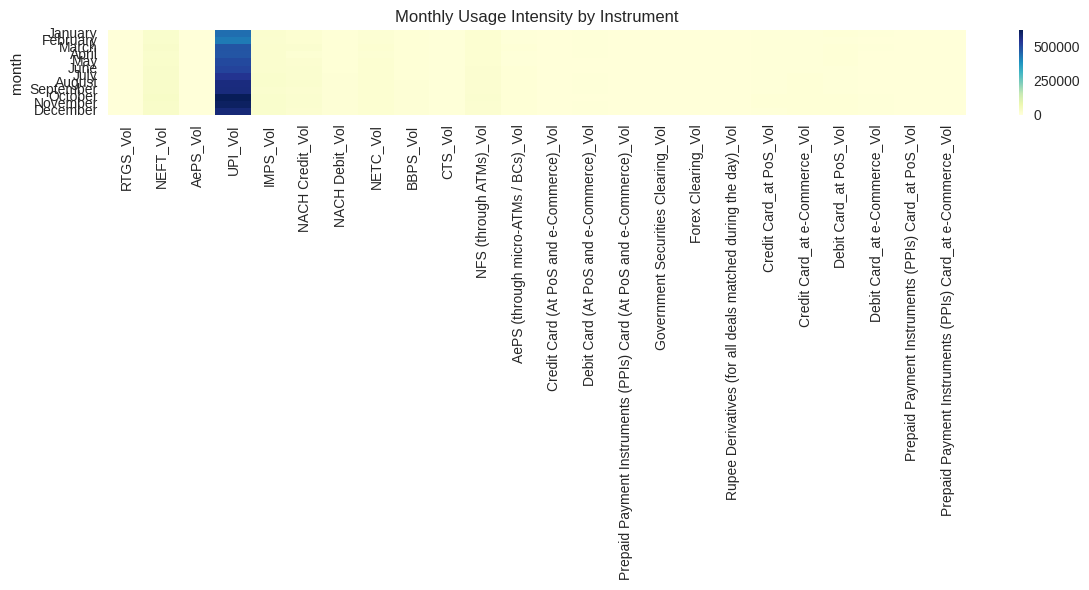

In [8]:
# Month-by-Instrument Usage Intensity

df_daily['month'] = df_daily['date'].dt.month_name()

month_instrument = (
    df_daily
    .groupby('month')[instrument_cols]
    .sum()
)

month_instrument = month_instrument.reindex([
    'January','February','March','April','May','June',
    'July','August','September','October','November','December'
])

plt.figure(figsize=(12,6))
sns.heatmap(month_instrument, cmap='YlGnBu')
plt.title("Monthly Usage Intensity by Instrument")
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/Hotfoot/figures/nb1_fig_02_month_instrument_heatmap.png")
plt.show()

### What we observe
- UPI shows consistently high usage across all months
- No month exhibits a sharp drop or spike unique to UPI
- Non-UPI instruments remain low-intensity and stable throughout the year

### Why this matters
- UPI dominance is structural, not seasonal
- Calendar effects do not explain UPI anomalies
- Monthly deviations should be interpreted as system or policy signals

### Key takeaway
UPI functions as an **always-on utility**, with no meaningful seasonal dependence,
strengthening the case for macro-level monitoring rather than seasonal adjustment.

## Monthly Aggregation of UPI Transaction Volume

### Why aggregate to monthly level?
Daily transaction data contains high-frequency noise caused by:
- Calendar effects
- Short-term user behavior
- Reporting variability

To understand **structural growth and long-term adoption**, we aggregate
UPI transaction volume at the **monthly level**.

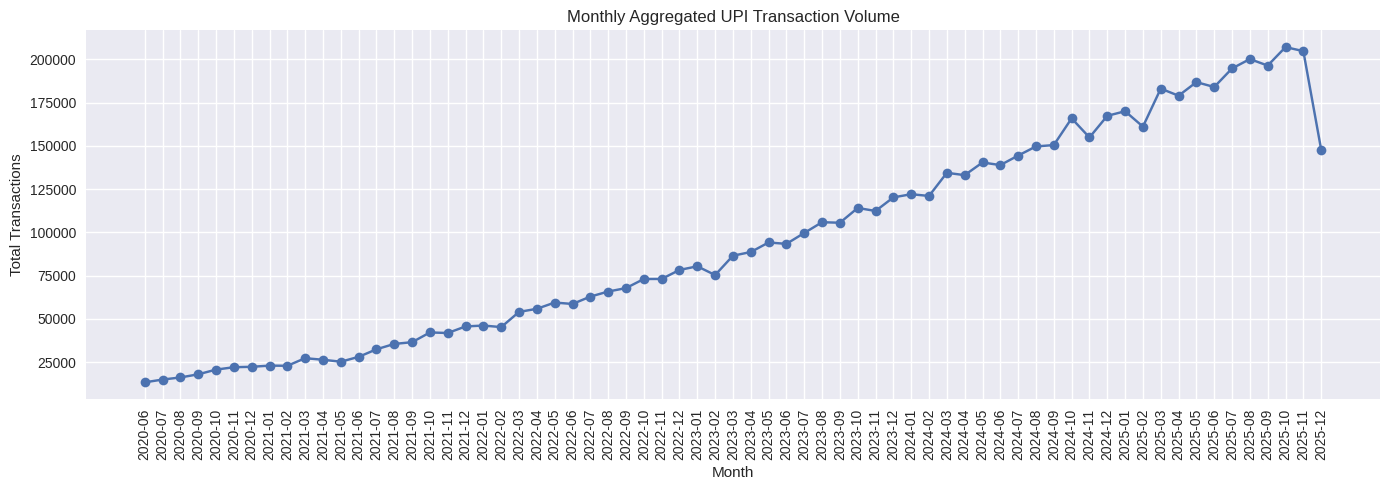

In [9]:
df_daily['year_month'] = df_daily['date'].dt.to_period('M')

monthly_upi = (
    df_daily
    .groupby('year_month')['UPI_Vol']
    .sum()
    .reset_index()
)

monthly_upi['year_month'] = monthly_upi['year_month'].astype(str)

plt.figure(figsize=(14,5))
plt.plot(monthly_upi['year_month'], monthly_upi['UPI_Vol'], marker='o')
plt.xticks(rotation=90)
plt.title("Monthly Aggregated UPI Transaction Volume")
plt.xlabel("Month")
plt.ylabel("Total Transactions")
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/Hotfoot/figures/nb1_fig_03_monthly_upi_volume.png")
plt.show()

### What we observe
- UPI transaction volume shows strong, sustained growth over time
- Growth accelerates after early adoption and remains consistently upward
- Minor month-to-month dips are temporary and quickly reversed

### Why this matters
- Confirms UPI growth is structural, not episodic
- Monthly aggregation smooths daily noise and reveals system trajectory
- Establishes a stable baseline for growth, volatility, and anomaly analysis

### Key takeaway
UPI has transitioned from early expansion to **scaled, system-level adoption**,
forming the foundation for all subsequent stability and risk evaluations.

## Monthly UPI Growth Stability

### Why this analysis?
High growth alone is not informative unless we understand its **stability**.

This analysis evaluates whether UPI growth:
- Remains within a normal operating range, or
- Exhibits unstable bursts that could signal systemic stress

We use a rolling baseline to distinguish **structural growth** from **temporary volatility**.

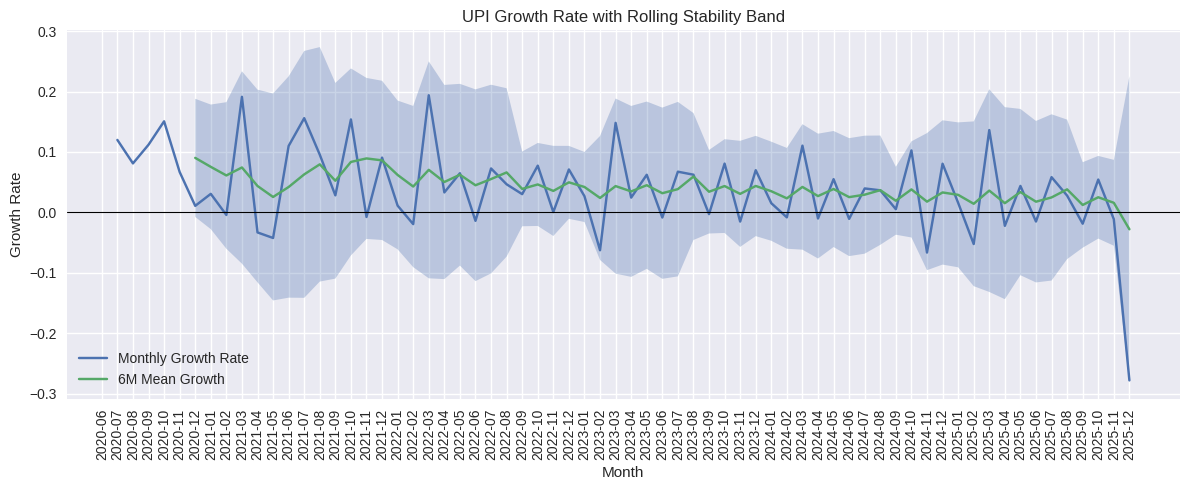

In [10]:
# Monthly growth rate
monthly_upi['upi_growth_rate'] = monthly_upi['UPI_Vol'].pct_change()

# Rolling baseline on growth
monthly_upi['growth_mean_6m'] = monthly_upi['upi_growth_rate'].rolling(6).mean()
monthly_upi['growth_std_6m'] = monthly_upi['upi_growth_rate'].rolling(6).std()

plt.figure(figsize=(12,5))
plt.plot(monthly_upi['year_month'], monthly_upi['upi_growth_rate'], label='Monthly Growth Rate')
plt.plot(monthly_upi['year_month'], monthly_upi['growth_mean_6m'], label='6M Mean Growth')

plt.fill_between(
    monthly_upi['year_month'],
    monthly_upi['growth_mean_6m'] - 2 * monthly_upi['growth_std_6m'],
    monthly_upi['growth_mean_6m'] + 2 * monthly_upi['growth_std_6m'],
    alpha=0.3
)

plt.axhline(0, color='black', linewidth=0.8)
plt.title("UPI Growth Rate with Rolling Stability Band")
plt.xlabel("Month")
plt.ylabel("Growth Rate")
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/Hotfoot/figures/nb1_fig_04_growth_rate_stability.png")
plt.show()

### What we observe
- UPI growth shows a clear downward trend over time
- Most monthly growth fluctuations remain within the rolling stability band
- Isolated sharp deviations occur, but do not persist

### Why this matters
- Growth moderation reflects system maturation, not weakness
- Absence of repeated band breaches indicates stable adoption
- Short-term volatility is absorbed without long-term disruption

### Key takeaway
UPI growth is **slowing but stabilizing**, consistent with a mature,
high-penetration digital payment system rather than a system under stress.

## Year-over-Year (YoY) Growth of Monthly UPI Transactions

### Why use YoY growth instead of month-over-month?
Month-over-month growth is heavily affected by:
- Calendar length differences
- Short-term noise
- Seasonal effects

Year-over-Year (YoY) growth compares each month to the **same month in the previous year**, making it the cleanest way to assess:
- True adoption momentum
- Growth sustainability
- Maturity signals

Incomplete trailing months are removed to avoid artificial distortions.

In [11]:
# YoY growth

# Remove incomplete trailing months (last month is often partial)
monthly_upi['date'] = pd.to_datetime(monthly_upi['year_month'])

last_complete_month = monthly_upi['date'].max() - pd.offsets.MonthEnd(1)
monthly_upi_clean = monthly_upi[monthly_upi['date'] <= last_complete_month].copy()

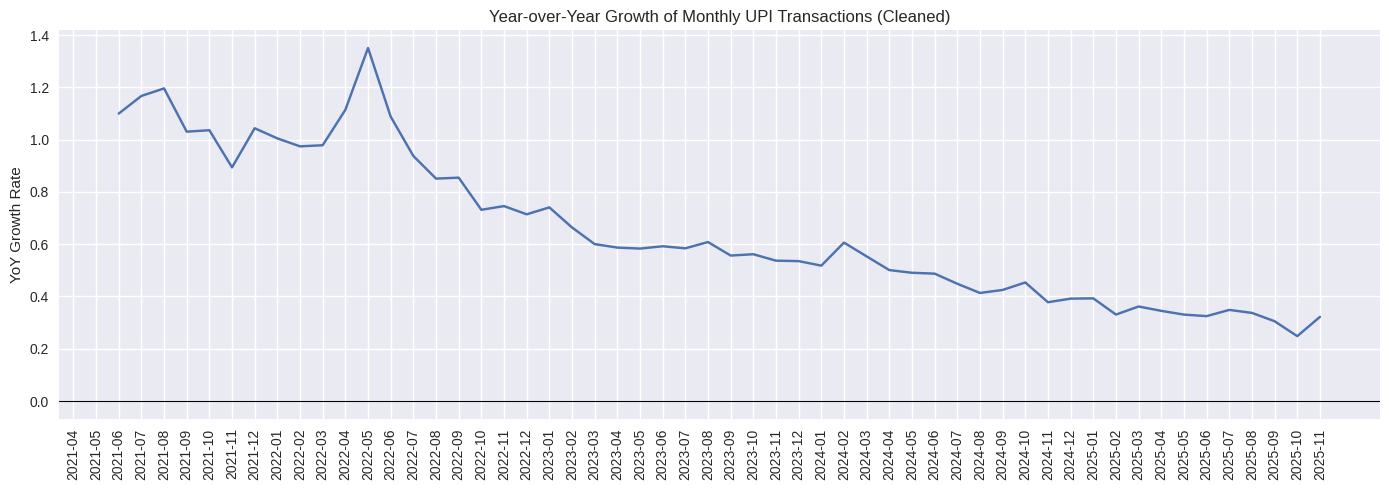

In [12]:
monthly_upi_clean['upi_yoy_growth'] = (
    monthly_upi_clean['UPI_Vol']
    .pct_change(12)
)

plt.figure(figsize=(14,5))
plt.plot(
    monthly_upi_clean['year_month'],
    monthly_upi_clean['upi_yoy_growth']
)
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(rotation=90)
plt.title("Year-over-Year Growth of Monthly UPI Transactions (Cleaned)")
plt.ylabel("YoY Growth Rate")
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/Hotfoot/figures/nb1_fig_05_upi_yoy_growth_cleaned.png")
plt.show()

### What we observe
- YoY growth is very high during early expansion phases
- Growth steadily moderates over time while remaining positive
- No prolonged negative YoY periods are observed

### What this indicates
- The decline in YoY growth reflects **scale effects**, not demand weakness
- UPI is transitioning from rapid expansion to a mature growth phase
- Absolute volumes continue to rise despite slower percentage growth

### Why this matters
High growth slowing at large scale is a **healthy system signal**, not a risk.
This distinction is critical to avoid misclassifying maturity as stagnation.

### Key takeaway
UPI exhibits **sustained, positive YoY growth**, consistent with a system
that has reached scale and is stabilizing rather than weakening.

## UPI Volume vs YoY Growth

Absolute volume and percentage growth tell different stories.
This comparison checks whether slowing growth rates indicate weakness
or simply reflect increasing scale.

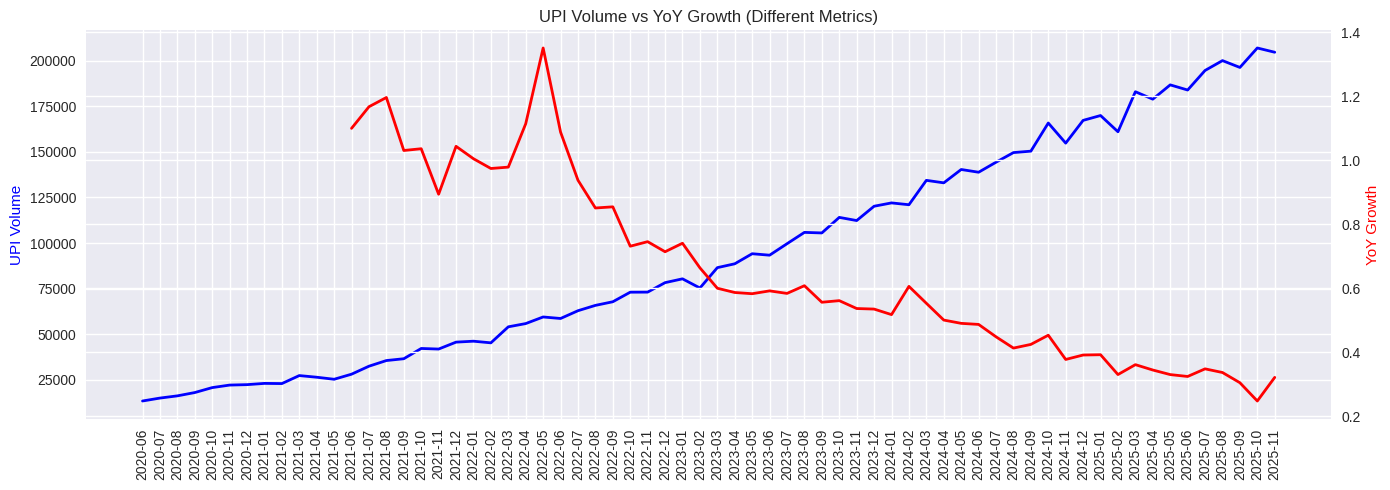

In [13]:
# UPI Volume vs YoY Growth

fig, ax1 = plt.subplots(figsize=(14, 5))

# Plot UPI Volume
ax1.plot(
    monthly_upi_clean['year_month'],
    monthly_upi_clean['UPI_Vol'],
    color='blue',
    linewidth=2
)
ax1.set_ylabel('UPI Volume', color='blue')

# Plot YoY Growth on secondary axis
ax2 = ax1.twinx()
ax2.plot(
    monthly_upi_clean['year_month'],
    monthly_upi_clean['upi_yoy_growth'],
    color='red',
    linewidth=2
)
ax2.set_ylabel('YoY Growth', color='red')

ax1.set_xticks(range(len(monthly_upi_clean)))
ax1.set_xticklabels(
    monthly_upi_clean['year_month'],
    rotation=90,
    ha='center'
)

plt.title("UPI Volume vs YoY Growth (Different Metrics)")
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/Hotfoot/figures/nb1_fig_06_upi_volume_vs_yoy_growth.png")
plt.show()

### Interpretation

- UPI transaction volume increases continuously over time
- Year-over-year growth declines smoothly as the base expands
- No abrupt drops or negative growth periods are observed

This pattern reflects **normal system maturation**:
large-scale systems add more volume but grow slower in percentage terms.

### Conclusion

Falling YoY growth alongside rising volume is **not a risk signal**.
It indicates that UPI has transitioned from rapid adoption
to stable, infrastructure-grade expansion.

## Statistical Baseline Check on Monthly UPI Volume

To distinguish normal growth-related fluctuations from true system shocks,
we compare monthly UPI volume against a rolling statistical baseline.

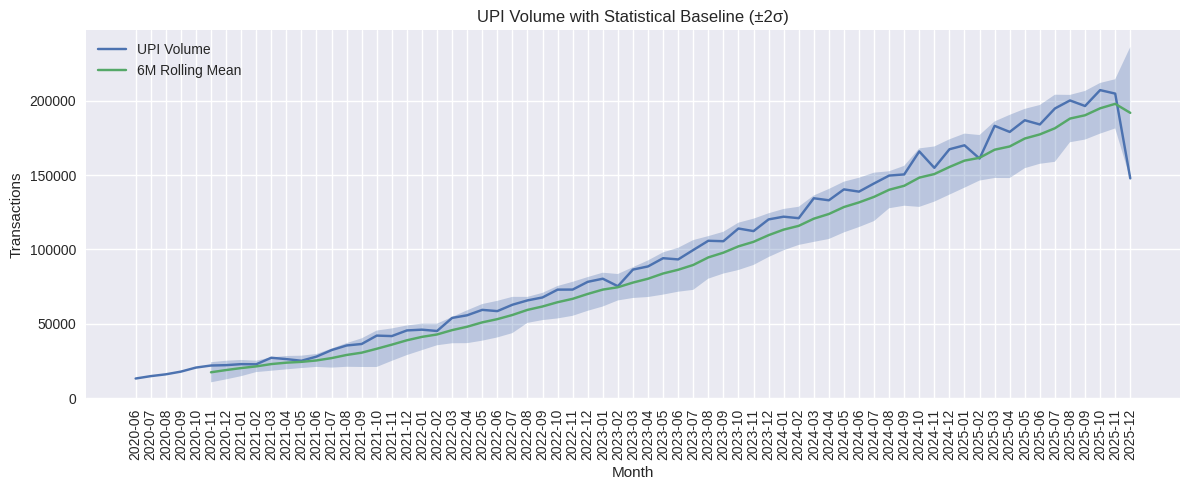

In [14]:
# Statistical Baseline and Control Band Analysis

# Ensure monthly data is sorted
monthly_upi = monthly_upi.sort_values('year_month').reset_index(drop=True)

# Rolling statistics
monthly_upi['vol_mean_6m'] = monthly_upi['UPI_Vol'].rolling(6).mean()
monthly_upi['vol_std_6m'] = monthly_upi['UPI_Vol'].rolling(6).std()

plt.figure(figsize=(12,5))
plt.plot(monthly_upi['year_month'], monthly_upi['UPI_Vol'], label='UPI Volume')
plt.plot(monthly_upi['year_month'], monthly_upi['vol_mean_6m'], label='6M Rolling Mean')

plt.fill_between(
    monthly_upi['year_month'],
    monthly_upi['vol_mean_6m'] - 2 * monthly_upi['vol_std_6m'],
    monthly_upi['vol_mean_6m'] + 2 * monthly_upi['vol_std_6m'],
    alpha=0.3
)

plt.title("UPI Volume with Statistical Baseline (±2σ)")
plt.xlabel("Month")
plt.ylabel("Transactions")
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/Hotfoot/figures/nb1_fig_07_upi_statistical_baseline.png")
plt.show()

### Interpretation

- Monthly UPI volume closely follows its rolling mean
- Most observations remain within the ±2σ control band
- The widening band reflects scale expansion, not instability
- No sustained breaches of the statistical envelope are observed

### Conclusion

UPI monthly volumes behave as a **stable and predictable system**.
Observed fluctuations are consistent with normal scaling effects
rather than structural stress or demand shocks.

## Monthly Z-Score Stability Check

To verify whether any monthly UPI volumes are statistically abnormal
relative to the full historical distribution, we compute a global z-score
for each month.

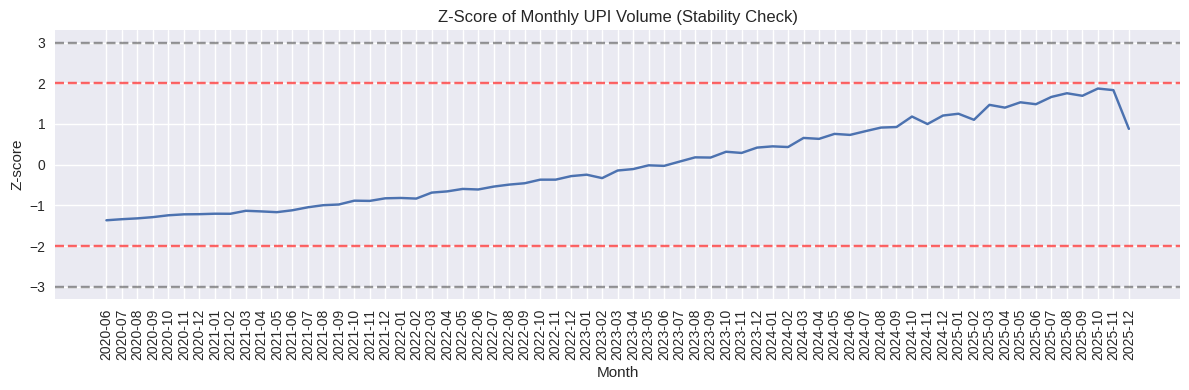

In [15]:
# Monthly Z-Score Stability Validation

monthly_upi['monthly_zscore_volume'] = (
    (monthly_upi['UPI_Vol'] - monthly_upi['UPI_Vol'].mean()) /
    monthly_upi['UPI_Vol'].std()
)

plt.figure(figsize=(12,4))
plt.plot(monthly_upi['year_month'], monthly_upi['monthly_zscore_volume'])
plt.axhline(2, linestyle='--', color='red', alpha=0.6)
plt.axhline(-2, linestyle='--', color='red', alpha=0.6)
plt.axhline(3, linestyle='--', color='black', alpha=0.4)
plt.axhline(-3, linestyle='--', color='black', alpha=0.4)

plt.title("Z-Score of Monthly UPI Volume (Stability Check)")
plt.xlabel("Month")
plt.ylabel("Z-score")
plt.xticks(rotation=90)
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/Hotfoot/figures/nb1_fig_08_monthly_zscore.png")
plt.show()

### Interpretation

- Monthly UPI volumes remain well within ±2σ throughout the period
- Z-scores increase gradually, reflecting long-term scale expansion
- No sudden spikes or threshold breaches are observed

### Conclusion

UPI monthly volumes show **no statistically abnormal behavior**.
Growth is smooth, predictable, and consistent with historical variability,
indicating a stable and mature system.

## Daily UPI Transaction Volume Trend

Before applying statistical tests or aggregation, we first examine
daily UPI transaction volume to understand the raw, high-frequency
behavior of the system.

This establishes the baseline growth pattern and highlights whether
daily fluctuations are structural signals or short-term noise.

In [16]:
upi_vol = df_daily['UPI_Vol']
upi_val = df_daily['UPI_Val']

# Total digital transaction volume (context)
instrument_cols = [c for c in df_daily.columns if c.endswith('_Vol')]
df_daily['TOTAL_DIGITAL_VOL'] = df_daily[instrument_cols].sum(axis=1)

df_daily[['date', 'UPI_Vol', 'TOTAL_DIGITAL_VOL']].head()

,date,UPI_Vol,TOTAL_DIGITAL_VOL
0,2020-06-01,476.96710,1017.78734
1,2020-06-02,476.78182,1041.81272
2,2020-06-03,456.25930,884.33717
3,2020-06-04,463.04959,1136.68830
4,2020-06-05,464.79398,996.94528


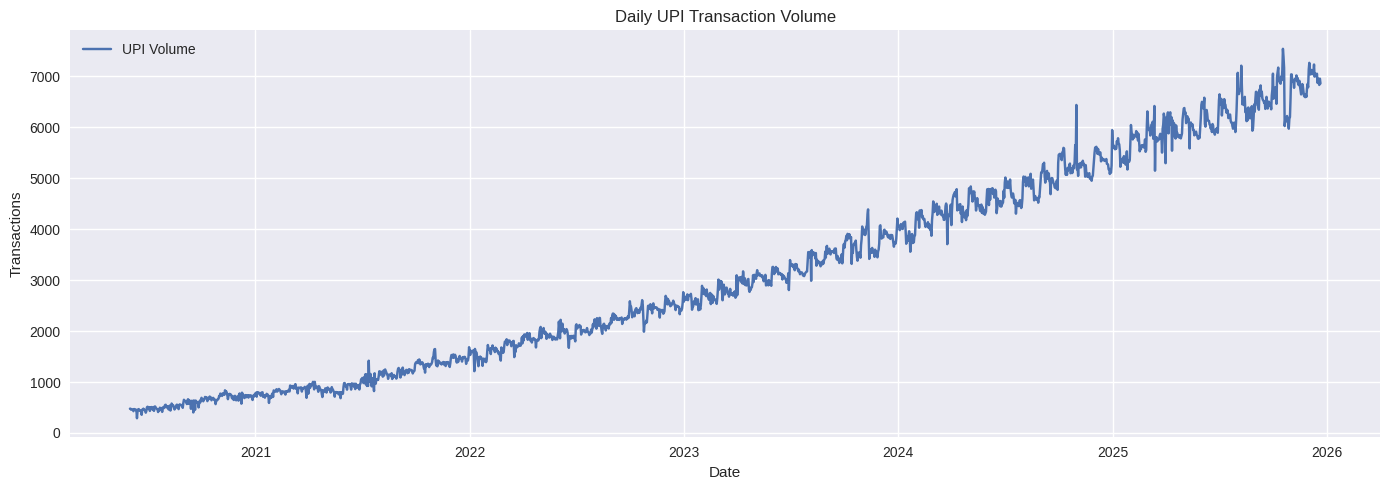

In [17]:
plt.figure(figsize=(14,5))
plt.plot(df_daily['date'], df_daily['UPI_Vol'], label='UPI Volume')
plt.title("Daily UPI Transaction Volume")
plt.xlabel("Date")
plt.ylabel("Transactions")
plt.legend()
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/Hotfoot/figures/nb1_fig_09_daily_upi_trend.png")
plt.show()

### Interpretation

- Daily UPI transaction volume follows a strong upward trajectory
- Regular short-term fluctuations are present throughout the period
- Absolute variability increases as transaction volume scales

### Conclusion

Daily UPI activity exhibits sustained growth with expected high-frequency
noise. At this resolution, fluctuations alone do not indicate instability
and must be evaluated using statistical filtering and higher-level
aggregation.

## STL Decomposition of Daily UPI Transaction Volume

To understand whether daily fluctuations in UPI volume are driven by
long-term adoption, recurring patterns, or irregular shocks, we apply
STL decomposition.

This allows us to separate trend, seasonality, and unexplained residuals,
which is essential before performing anomaly detection.

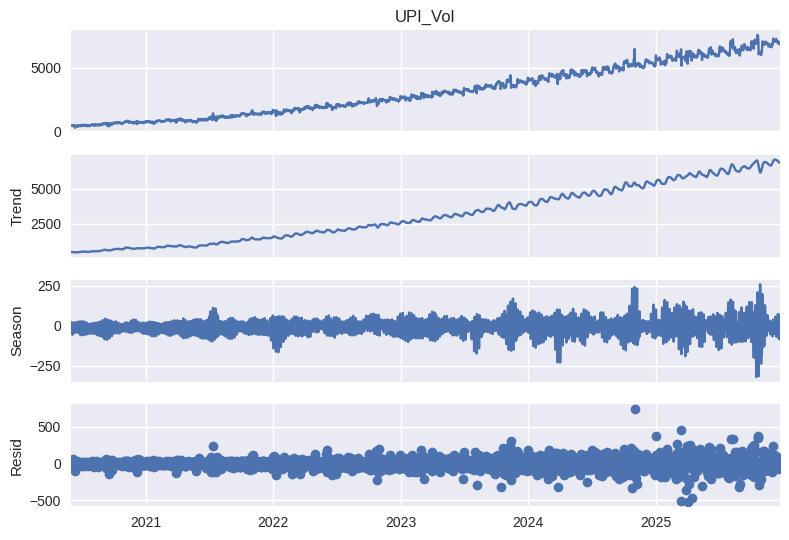

In [18]:
stl = STL(df_daily.set_index('date')['UPI_Vol'], period=7)
result = stl.fit()

result.plot()
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Hotfoot/figures/nb1_fig_10_upi_stl_decomposition.png")
plt.show()

## Interpreting STL Decomposition of Daily UPI Volume

### What this decomposition shows
### What we observe

- The trend component increases smoothly over time
- Seasonal patterns are regular and stable
- Residuals fluctuate around zero with occasional spikes
- Residual dispersion increases as volume scales

### What this indicates

- Long-term growth is the dominant driver of UPI volume
- Short-term oscillations are systematic and recurring
- Unexplained deviations are isolated rather than persistent

### Why this matters

By separating expected structure from noise, STL ensures that
subsequent anomaly detection focuses only on genuinely unusual behavior,
not normal growth or seasonality.

This prevents false alarms in high-frequency data.

### Key takeaway

Most daily variation in UPI volume is explained by trend and seasonality.
Residual deviations are episodic signals, not evidence of systemic stress.

## UPI Share of Total Digital Transaction Volume

To understand UPI’s importance relative to the entire digital payments
ecosystem, we compute its daily share of total digital transaction volume.

This normalization helps distinguish UPI-specific behavior from
system-wide digital growth.

In [19]:
# Compute UPI Share of Total Digital Volume
df_daily['UPI_SHARE'] = df_daily['UPI_Vol'] / df_daily['TOTAL_DIGITAL_VOL']

df_daily[['date', 'UPI_Vol', 'TOTAL_DIGITAL_VOL', 'UPI_SHARE']].head()

,date,UPI_Vol,TOTAL_DIGITAL_VOL,UPI_SHARE
0,2020-06-01,476.96710,1017.78734,0.468631
1,2020-06-02,476.78182,1041.81272,0.457646
2,2020-06-03,456.25930,884.33717,0.515934
3,2020-06-04,463.04959,1136.68830,0.407367
4,2020-06-05,464.79398,996.94528,0.466218


### What we observe

- UPI accounts for a large fraction of daily digital transaction volume
- Daily share values fluctuate over time
- UPI consistently contributes a substantial portion of total activity

### What this indicates

- UPI is a core component of the digital payments ecosystem
- Day-to-day share changes reflect relative movement across instruments,
  not just UPI behavior in isolation

### Why this matters

UPI share provides context for interpreting volume spikes and anomalies.
It helps determine whether unusual UPI behavior is system-wide or
specific to UPI.

This metric is critical for later anomaly and substitution analysis.

### Key takeaway

UPI consistently represents a significant share of daily digital
transactions, with natural short-term variability that requires
aggregation before drawing structural conclusions.

## Daily UPI Share of Total Digital Transactions

To evaluate how UPI’s role within the digital payments ecosystem evolves
over time, we analyze its daily share of total digital transaction volume.

This helps identify whether changes in UPI activity are driven by
UPI-specific behavior or by broader system-level shifts.

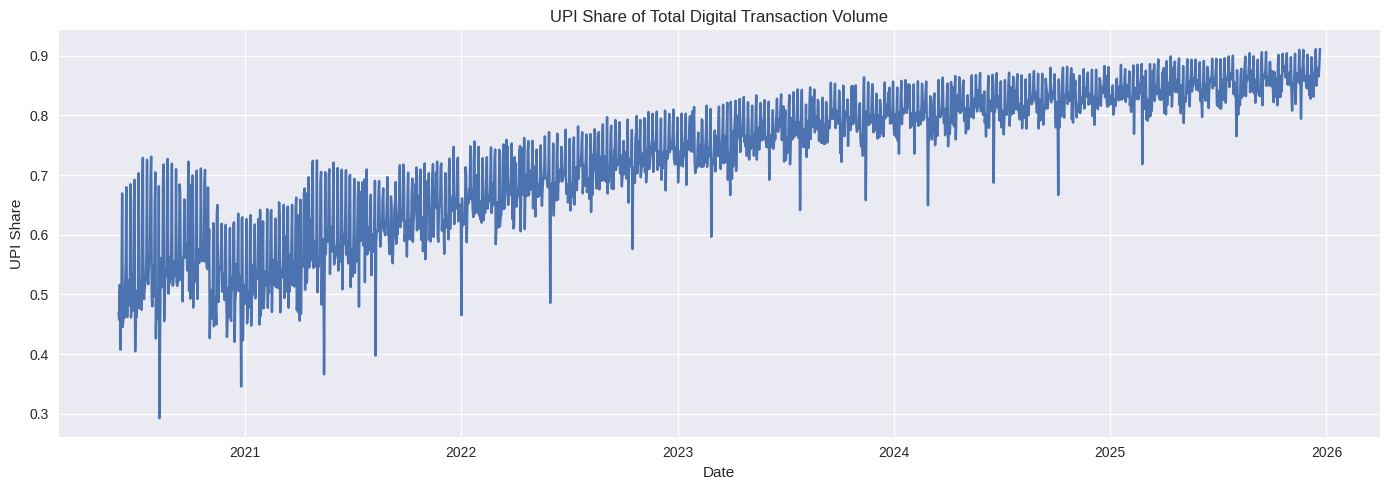

In [20]:
# Plot UPI Share Over Time
plt.figure(figsize=(14,5))
plt.plot(df_daily['date'], df_daily['UPI_SHARE'])
plt.title("UPI Share of Total Digital Transaction Volume")
plt.xlabel("Date")
plt.ylabel("UPI Share")
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/Hotfoot/figures/nb1_fig_11_upi_share_trend.png")
plt.show()

### What we observe

- UPI share increases steadily over the full period
- Day-to-day fluctuations are frequent but short-lived
- Occasional sharp downward spikes appear but recover quickly
- Variability narrows as UPI share rises

### What this indicates

- UPI is becoming an increasingly dominant component of digital payments
- Daily dips are driven by temporary non-UPI surges rather than UPI decline
- Rising share leads to greater relative stability over time

### Why this matters

UPI share contextualizes volume movements by showing relative positioning
within the ecosystem. It helps distinguish UPI-specific stress from
system-wide changes and informs later anomaly and substitution analysis.

### Key takeaway

UPI’s share of daily digital transactions rises consistently, with
short-lived fluctuations that normalize quickly—indicating growing
dominance without structural instability.

## Detecting Decoupling Periods Using UPI Share

To identify days when UPI behaves differently from the overall digital
payments system, we monitor abnormal movements in UPI’s share of total
digital transaction volume.

This allows us to detect **relative stress or substitution effects** that
may not be visible in absolute UPI volume alone.

In [21]:
# Detect Decoupling Periods (Share Anomalies)
window = 30
share_mean = df_daily['UPI_SHARE'].rolling(window).mean()
share_std = df_daily['UPI_SHARE'].rolling(window).std()

df_daily['upi_share_zscore'] = (df_daily['UPI_SHARE'] - share_mean) / share_std

share_anomalies = df_daily[np.abs(df_daily['upi_share_zscore']) > 3]

share_anomalies[['date', 'UPI_SHARE', 'upi_share_zscore']].head()

,date,UPI_SHARE,upi_share_zscore
434,2021-08-09,0.397533,-3.062888
579,2022-01-01,0.465220,-3.348315
729,2022-05-31,0.485642,-3.939005
868,2022-10-17,0.575957,-3.445300
1001,2023-02-27,0.596529,-3.325297


### What we observe

- All detected anomalies have negative z-scores
- UPI share temporarily falls well below its recent rolling baseline
- Events are isolated rather than persistent over multiple days

### What this indicates

- These are **relative decoupling events**, not absolute UPI failures
- Non-UPI instruments briefly gain share during these periods
- The system corrects quickly back to normal behavior

### Why this matters

UPI share anomalies help distinguish between:
- UPI-specific relative stress
- System-wide digital payment fluctuations

This prevents misinterpreting temporary substitution effects as
structural or systemic risk.

### Key takeaway

UPI share decoupling events occur occasionally, but they are **short-lived,
non-persistent, and self-correcting**, indicating no sustained erosion of
UPI’s system-level dominance.

## Daily Growth Rate of UPI Transactions

To understand how stable or volatile UPI usage is at a daily level, we
analyze the **day-on-day growth rate** of UPI transaction volume.

This transformation shifts the focus from absolute scale to **relative
daily change**, helping identify whether growth behaves smoothly or is
dominated by short-term noise.

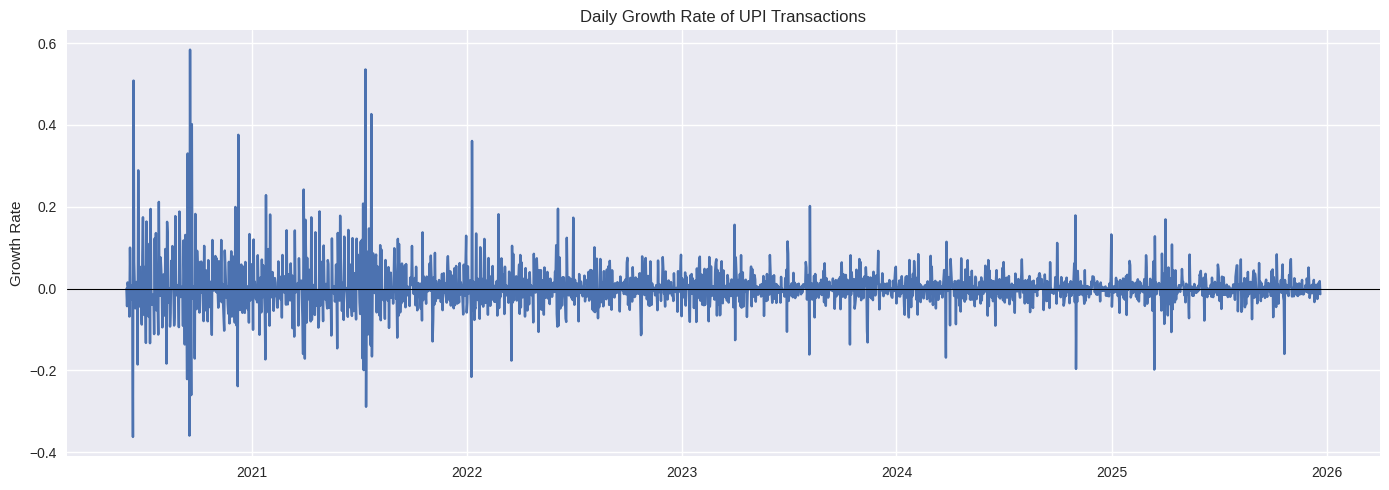

In [22]:
df_daily['upi_daily_growth'] = df_daily['UPI_Vol'].pct_change()

plt.figure(figsize=(14,5))
plt.plot(df_daily['date'], df_daily['upi_daily_growth'])
plt.axhline(0, color='black', linewidth=0.8)
plt.title("Daily Growth Rate of UPI Transactions")
plt.ylabel("Growth Rate")
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/Hotfoot/figures/nb1_fig_12_upi_growth_rate.png")
plt.show()

### What we observe

- Early periods show very large positive and negative daily growth swings
- Growth volatility reduces steadily over time
- Later periods cluster tightly around zero with fewer extreme spikes
- Negative growth days occur but are short-lived

### What this indicates

- Early UPI growth was **irregular and adoption-driven**
- As the system scaled, growth became **more consistent and predictable**
- Daily volatility declined even as absolute transaction volume increased

### Why this matters

Daily growth rates are inherently noisy, even in healthy systems.
This means:
- Single-day spikes or drops should not be treated as risk signals
- Persistence matters more than magnitude
- Daily signals require aggregation for system-level interpretation

This directly motivates the move toward **monthly analysis** for
stability, regime detection, and risk assessment.

### Key takeaway

UPI’s daily growth behavior evolves from **volatile expansion** to
**stable maturation**, confirming that short-term noise should not be
confused with systemic instability.

## Rolling 30-Day Trend Slope of UPI Volume

Daily volumes and growth rates can be noisy and hard to interpret in isolation.
To understand whether UPI is **accelerating or decelerating over short horizons**,
we compute a rolling **30-day trend slope**.

This measures the *direction and strength of recent momentum*, rather than
one-day fluctuations.

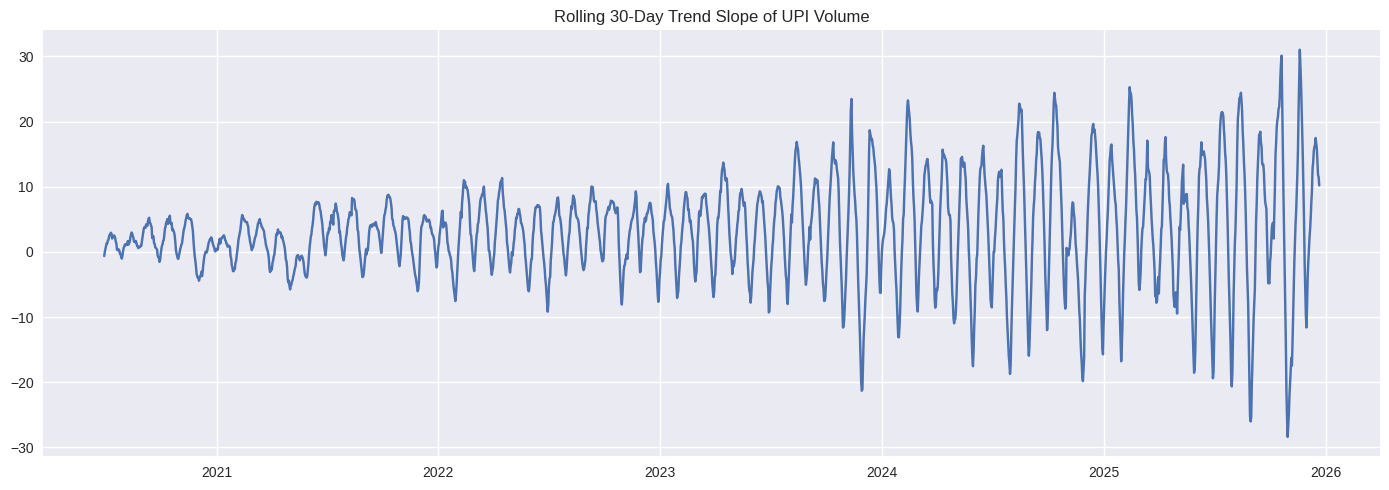

In [23]:
window = 30

df_daily['upi_trend_slope'] = (
    df_daily['UPI_Vol']
    .rolling(window)
    .apply(lambda x: np.polyfit(range(len(x)), x, 1)[0], raw=False)
)

plt.figure(figsize=(14,5))
plt.plot(df_daily['date'], df_daily['upi_trend_slope'])
plt.title("Rolling 30-Day Trend Slope of UPI Volume")
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/Hotfoot/figures/nb1_fig_13_upi_trend_slope.png")
plt.show()

### What we observe

- The trend slope oscillates frequently but remains mostly positive
- Negative slope periods appear regularly but are short-lived
- The amplitude of swings increases over time

### What this indicates

- UPI continues to grow in the medium term, even during temporary slowdowns
- Larger swings reflect a growing transaction base, not instability
- Negative momentum episodes represent normal corrections, not contractions

### Why this matters

This metric helps distinguish:
- Temporary slowdowns → normal system behavior
- Sustained negative momentum → potential structural risk

The absence of long, persistent negative slopes suggests
UPI does not enter prolonged decline phases.

### Key takeaway

UPI exhibits **fluctuating but resilient growth momentum**.
Short-term decelerations correct quickly, reinforcing the system’s
structural stability and maturity.

## Average UPI Transactions by Day of Week

Before treating daily spikes or drops as anomalies, we first check
whether UPI usage follows a strong weekday–weekend pattern.

If large differences exist across days of the week, then some daily
fluctuations may simply reflect calendar effects rather than
system-level signals.

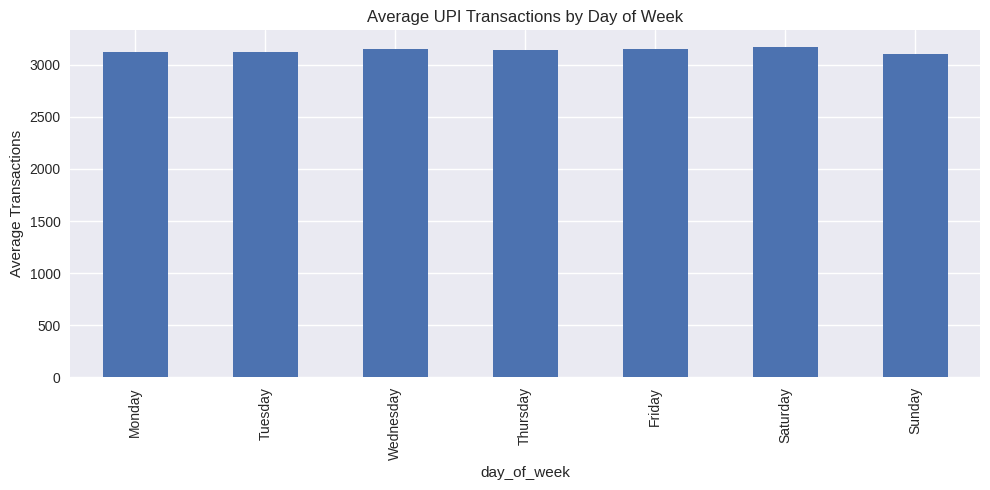

In [24]:
df_daily['day_of_week'] = df_daily['date'].dt.day_name()

dow_avg = (
    df_daily
    .groupby('day_of_week')['UPI_Vol']
    .mean()
    .reindex([
        'Monday','Tuesday','Wednesday',
        'Thursday','Friday','Saturday','Sunday'
    ])
)

plt.figure(figsize=(10,5))
dow_avg.plot(kind='bar')
plt.title("Average UPI Transactions by Day of Week")
plt.ylabel("Average Transactions")
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/Hotfoot/figures/nb1_fig_14_upi_dayofweek.png")
plt.show()

### What we observe

- Average UPI transaction volume is very similar across all days
- No sharp drop-off is visible on weekends
- Sunday shows only a small, non-material dip

### What this indicates

- UPI usage is not tied to business days
- Transactions are driven largely by consumer and peer-to-peer activity
- Day-of-week seasonality is weak and predictable

### Why this matters

Since weekday effects are minimal:
- Daily spikes or drops cannot be explained by calendar structure alone
- Detected anomalies are less likely to be routine scheduling effects
- Daily monitoring can focus on true behavioral or system changes

### Key takeaway

UPI functions as a **7-day, always-on payment system**.
Day-of-week patterns do not materially distort daily volume,
making daily anomaly detection more reliable.

## UPI Growth vs Total Digital Growth

Before interpreting UPI growth as substitution or dominance,
we test whether UPI growth moves *with* or *against* overall
digital transaction growth.

If UPI growth were substituting other instruments, we would
expect UPI to grow when total digital growth declines.
This scatter plot helps distinguish **substitution** from
**complementary ecosystem growth**.

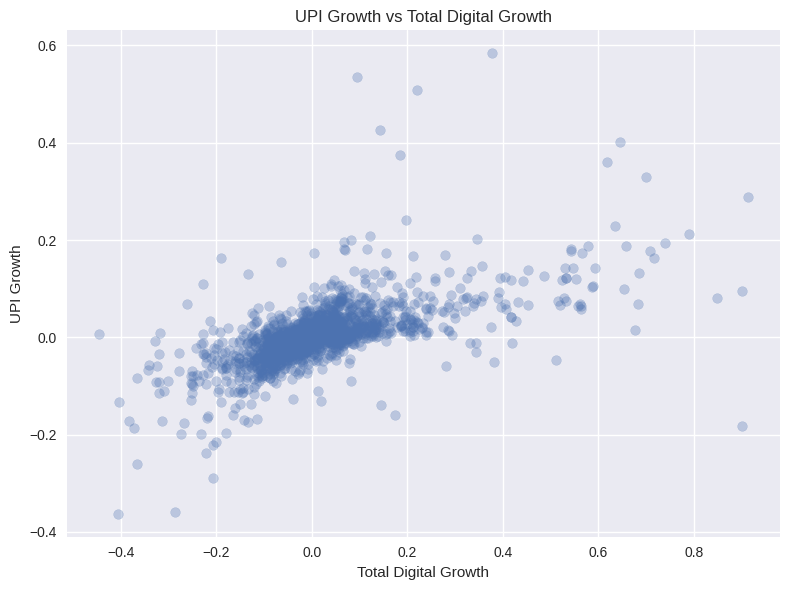

In [25]:
df_daily['total_digital_growth'] = df_daily['TOTAL_DIGITAL_VOL'].pct_change()

plt.figure(figsize=(8,6))
plt.scatter(
    df_daily['total_digital_growth'],
    df_daily['upi_daily_growth'],
    alpha=0.3
)
plt.xlabel("Total Digital Growth")
plt.ylabel("UPI Growth")
plt.title("UPI Growth vs Total Digital Growth")
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/Hotfoot/figures/nb1_fig_15_substitution_test.png")
plt.show()

### What we observe

- Most points cluster along an upward-sloping diagonal
- Days with high total digital growth generally coincide with high UPI growth
- Very few days show UPI growth when total digital growth is strongly negative

### What this indicates

- UPI growth is positively correlated with overall digital growth
- UPI expands when the digital ecosystem expands
- There is no consistent inverse relationship suggesting substitution

### Why this matters

This result rules out a key risk hypothesis:
that UPI growth comes at the expense of other digital instruments.

Instead, it shows that:
- UPI growth reflects system-wide demand
- Daily UPI anomalies are largely ecosystem-driven
- Relative share shifts are temporary, not structural

### Key takeaway

UPI growth is **complementary to total digital growth**, not substitutive.

At the daily level, UPI behaves as the leading channel of
a growing digital ecosystem, rather than a zero-sum competitor.

## UPI Contribution to Total Digital Transaction Growth

Correlation tells us whether UPI and total digital transactions move together,
but it does not tell us **how much UPI actually contributes** to system-wide growth.

This analysis measures the **direct contribution of UPI to daily changes in total
digital transaction volume**.

By examining contribution rather than correlation, we ensure that UPI’s role is
interpreted in **causal and proportional terms**, not just directional alignment.

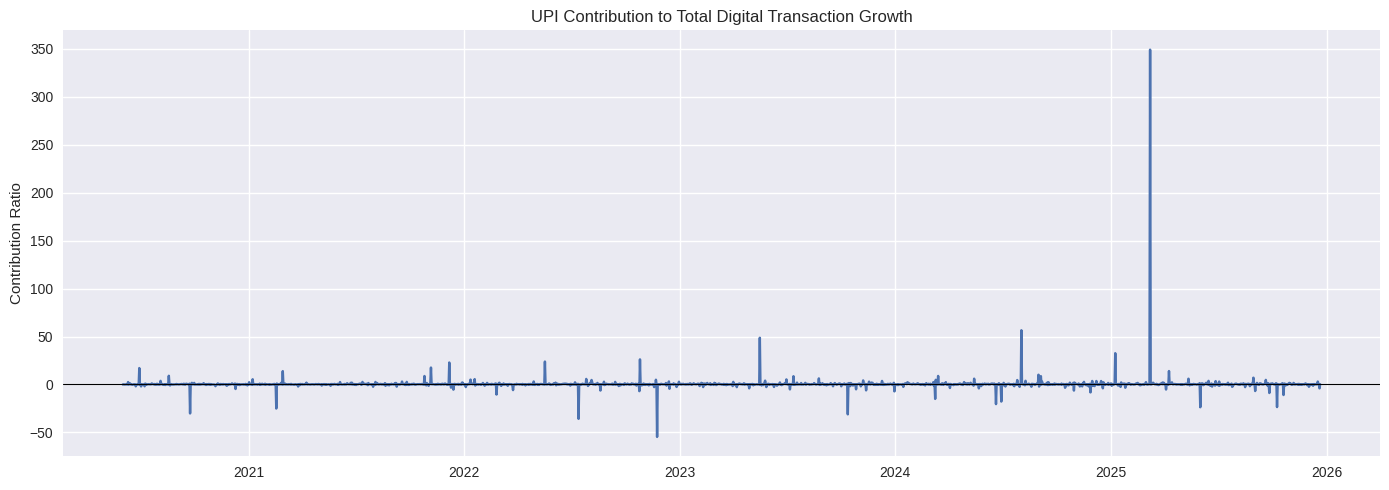

In [26]:
df_daily['upi_contribution'] = (
    df_daily['UPI_Vol'].diff() /
    df_daily['TOTAL_DIGITAL_VOL'].diff()
)

plt.figure(figsize=(14,5))
plt.plot(df_daily['date'], df_daily['upi_contribution'])
plt.axhline(0, color='black', linewidth=0.8)
plt.title("UPI Contribution to Total Digital Transaction Growth")
plt.ylabel("Contribution Ratio")
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/Hotfoot/figures/nb1_fig_16_upi_growth_contribution.png")
plt.show()

### What we observe

- UPI contribution fluctuates around zero with frequent positive regions
- Both positive and negative contribution days are present
- Extreme spikes appear but are rare and isolated
- No long, continuous periods of negative contribution are visible

### What this indicates

- UPI regularly contributes to overall digital transaction growth
- Contribution varies day to day due to transaction mix and reporting effects
- Negative contribution days are episodic, not persistent
- Large spikes are driven by small-denominator effects, not systemic shifts

### Why this matters

This analysis confirms that:
- UPI is not consistently offsetting or suppressing system growth
- Daily fluctuations do not translate into structural dependence or fragility
- UPI acts as a **frequent co-driver**, not an unstable or dominant distorter

It also explains why daily contribution metrics must be interpreted
with caution and supported by aggregation and persistence checks.

### Key takeaway

UPI is a **regular and positive contributor** to overall digital transaction growth,
with short-term fluctuations driven by daily dynamics rather than structural risk.

This reinforces the conclusion that UPI functions as a **foundational growth engine**
within a healthy and expanding digital payments ecosystem.

# Part 2: Resilience & Stress Testing
### Why compute Substitution Flags and Z-Scores?
Growth is easy to see, but **resilience** is hidden. We compute Z-scores to strip away the 'expected' growth and find the 'unexpected' shocks. We use **Substitution Analysis** to see if, when UPI slows down, people switch to IMPS or Debit Cards. This proves the ecosystem has 'backup' pathways.

In [27]:
window = 30
rolling_mean = upi_vol.rolling(window).mean()
rolling_std = upi_vol.rolling(window).std()

df_daily['upi_zscore'] = (upi_vol - rolling_mean) / rolling_std

## System-Level Anomaly Detection with Persistence Filtering

Daily transaction data is naturally noisy. Single-day spikes or drops can occur
due to calendar effects, reporting delays, or short-lived operational factors.

To avoid false alarms, we define a **system-level anomaly** only when deviations
are statistically extreme **and** examine whether such deviations **persist
across consecutive days**.

This step ensures that only **economically meaningful system stress**, rather
than transient noise, is flagged for further analysis.

In [28]:
df_daily['system_anomaly_flag'] = (
    (np.abs(df_daily['upi_zscore']) > 3) |
    (np.abs(df_daily['upi_share_zscore']) > 3)
)
df_daily['anomaly_binary'] = df_daily['system_anomaly_flag'].astype(int)

df_daily['anomaly_run_length'] = (
    df_daily['anomaly_binary']
    .groupby((df_daily['anomaly_binary'] != df_daily['anomaly_binary'].shift()).cumsum())
    .cumsum()
)

# Select only the relevant columns for system-level anomaly analysis
system_anomaly_df = df_daily[
    ['date', 'UPI_Vol', 'UPI_SHARE', 'upi_zscore', 'upi_share_zscore',
     'system_anomaly_flag', 'anomaly_run_length']
].copy()

# Save to CSV
system_anomaly_df.to_csv(
    "/content/drive/MyDrive/Hotfoot/outputs/nb1_system_daily_anomalies.csv",
    index=False
)

system_anomaly_df.head()

,date,UPI_Vol,UPI_SHARE,upi_zscore,upi_share_zscore,system_anomaly_flag,anomaly_run_length
0,2020-06-01,476.96710,0.468631,NaN,NaN,False,0
1,2020-06-02,476.78182,0.457646,NaN,NaN,False,0
2,2020-06-03,456.25930,0.515934,NaN,NaN,False,0
3,2020-06-04,463.04959,0.407367,NaN,NaN,False,0
4,2020-06-05,464.79398,0.466218,NaN,NaN,False,0


### What we observe

- The majority of days are **not flagged** as system anomalies
- Initial rows show:
  - `system_anomaly_flag = False`
  - `anomaly_run_length = 0`
- Anomalies, when they occur, are **isolated rather than persistent**

### What this indicates

- Extreme deviations in UPI volume or UPI share are **rare**
- Most detected deviations do **not continue across multiple days**
- The digital payment system rapidly reverts to normal behavior

### Why this matters

Systemic risk is defined by **persistence**, not magnitude alone.

By explicitly tracking consecutive anomaly runs:
- One-off reporting or calendar effects are filtered out
- Only sustained abnormal behavior is escalated
- False positives in risk monitoring are avoided

This makes the anomaly detection **operationally usable** for regulators
and system operators.

### Key takeaway

UPI exhibits **high day-to-day resilience**.

Statistically extreme deviations occur occasionally, but they **do not persist**,
indicating the absence of sustained system-level stress at the daily resolution.

## Compute Growth of Other Instruments

## Non-UPI Growth Computation for Substitution Analysis

To test whether users temporarily shift away from UPI during stress periods,
we need a **system-level view of alternative payment instruments**.

This step computes:
- Daily growth for major non-UPI payment rails
- An aggregated **Non-UPI volume** and **Non-UPI growth signal**

This creates a counterfactual benchmark:
> *If UPI slows, does the rest of the digital ecosystem absorb the activity?*


In [29]:
# Compute daily growth rates for important instruments

important_instruments = [
    'IMPS_Vol',
    'NEFT_Vol',
    'RTGS_Vol',
    'AePS_Vol',
    'NACH Credit_Vol',
    'NACH Debit_Vol',
    'NETC_Vol',
    'BBPS_Vol',
    'CTS_Vol',
    'NFS (through ATMs)_Vol',
    'AePS (through micro-ATMs / BCs)_Vol',
    'Credit Card (At PoS and e-Commerce)_Vol',
    'Debit Card (At PoS and e-Commerce)_Vol',
    'Prepaid Payment Instruments (PPIs) Card (At PoS and e-Commerce)_Vol'
]

# Convert relevant columns to numeric before calculating growth rates
for col in important_instruments:
    if col in df_daily.columns and df_daily[col].dtype == 'object':
        df_daily[col] = pd.to_numeric(df_daily[col], errors='coerce').fillna(0)

# Compute growth safely (only if column exists)
for col in important_instruments:
    if col in df_daily.columns:
        df_daily[f"{col}_growth"] = df_daily[col].pct_change()

# Aggregate Non-UPI Volume & Growth

non_upi_cols = [c for c in important_instruments if c in df_daily.columns]

df_daily['NON_UPI_VOL'] = df_daily[non_upi_cols].sum(axis=1)
df_daily['NON_UPI_growth'] = df_daily['NON_UPI_VOL'].pct_change()

# Quick sanity check
df_daily[
    ['date', 'UPI_Vol', 'NON_UPI_VOL', 'NON_UPI_growth']
].head()

,date,UPI_Vol,NON_UPI_VOL,NON_UPI_growth
0,2020-06-01,476.96710,540.82024,NaN
1,2020-06-02,476.78182,565.03090,0.044767
2,2020-06-03,456.25930,428.07787,-0.242381
3,2020-06-04,463.04959,673.63871,0.573636
4,2020-06-05,464.79398,532.15130,-0.210035


### What we observe

- Non-UPI growth shows **large daily swings**, both positive and negative
- Growth volatility is higher than UPI at the daily level
- Non-UPI activity is clearly **responsive**, not static

### What this indicates

- Alternative payment instruments actively absorb transaction demand
- The digital ecosystem does not rely on UPI alone for daily throughput
- Temporary shifts in payment mix are feasible at short horizons

### Why this matters

This enables a **true substitution test**:
- UPI ↓ and Non-UPI ↓ → system-wide slowdown
- UPI ↓ and Non-UPI ↑ → UPI-specific stress with user rerouting

Without this aggregation, UPI drops could be misinterpreted as
ecosystem weakness instead of **behavioral substitution**.

### Key takeaway

Non-UPI instruments provide a **functional fallback layer**.

Their active growth dynamics allow us to distinguish
**UPI-specific stress** from **system-level shocks** in later analysis.

## Substitution Detection: Identifying UPI Stress with Fallback Usage

To understand whether drops in UPI activity reflect **system-wide stress**
or **temporary user rerouting**, we explicitly test for substitution behavior.

This step flags days where:
- UPI shows statistically significant stress, **and**
- Other digital payment instruments grow simultaneously

Such days indicate **behavioral substitution**, not ecosystem failure.

In [30]:
# Substitution condition:
# UPI is under stress AND non-UPI instruments grow
df_daily['substitution_flag'] = (
    (df_daily['upi_zscore'] < -3) &
    (df_daily['NON_UPI_growth'] > 0)
)

# Extract substitution candidates
substitution_days = df_daily[df_daily['substitution_flag']]

substitution_days[
    ['date', 'UPI_Vol', 'NON_UPI_VOL', 'upi_zscore', 'NON_UPI_growth']
].head()

,date,UPI_Vol,NON_UPI_VOL,upi_zscore,NON_UPI_growth
301,2021-03-29,689.60,765.04868,-3.610099,0.828306
876,2022-10-25,1988.31,586.97505,-3.214329,0.283661
1393,2024-03-25,3707.24,796.09923,-3.035074,0.316872


### What we observe

- Only a **small number of days** satisfy the substitution condition
- On these days:
  - UPI volume is sharply below its recent baseline
  - Non-UPI transaction volume grows simultaneously
- Events are **isolated**, not persistent

### What this indicates

- Users temporarily **reroute transactions** when UPI weakens
- Digital payment activity continues through alternative rails
- UPI stress does **not** imply digital payment abandonment

### Why this matters

This distinction prevents misclassification:
- UPI ↓ alone ≠ system risk
- UPI ↓ + Non-UPI ↑ = **resilient ecosystem response**

It shows that:
- The ecosystem has effective fallback mechanisms
- User trust in digital payments remains intact

### Key takeaway

Short-lived UPI stress episodes are **absorbed by other instruments**.

This behavior signals **system resilience**, not structural weakness,
and supports treating these events as **operational noise**, not systemic risk.

## Quantifying Substitution During UPI Stress

To move beyond individual examples, we summarize **how often UPI stress coincides
with increased activity in non-UPI instruments**.

This provides a simple, decision-ready measure of
**ecosystem resilience vs single-rail dependency**.

In [31]:
summary_substitution = pd.DataFrame({
    "Total_UPI_Stress_Days": [
        (df_daily['upi_zscore'] < -3).sum()
    ],
    "Substitution_Days": [
        df_daily['substitution_flag'].sum()
    ]
})

summary_substitution["Substitution_Ratio"] = (
    summary_substitution["Substitution_Days"] /
    summary_substitution["Total_UPI_Stress_Days"]
)

summary_substitution

,Total_UPI_Stress_Days,Substitution_Days,Substitution_Ratio
0,5,3,0.6


### What we observe

- Total UPI stress days: **5**
- Substitution days: **3**
- Substitution ratio: **60%**

### What this indicates

- On most UPI stress days, users **continue transacting digitally**
- Demand is partially absorbed by **non-UPI payment rails**
- UPI stress is often **instrument-specific**, not system-wide

### Why this matters

This prevents misinterpretation of UPI slowdowns:
- UPI ↓ ≠ digital payment failure
- Substitution reflects **user adaptability and system redundancy**

### Key takeaway

> A 60% substitution ratio indicates a **resilient, multi-rail ecosystem** —
> UPI is dominant, but not a single point of failure.

## Visual Validation of Substitution During UPI Stress

To complement the numerical substitution metrics, we visually inspect
whether **non-UPI transaction volume increases when UPI is under stress**.

This plot helps confirm that detected substitution days are
**behaviorally meaningful**, not just statistically flagged.

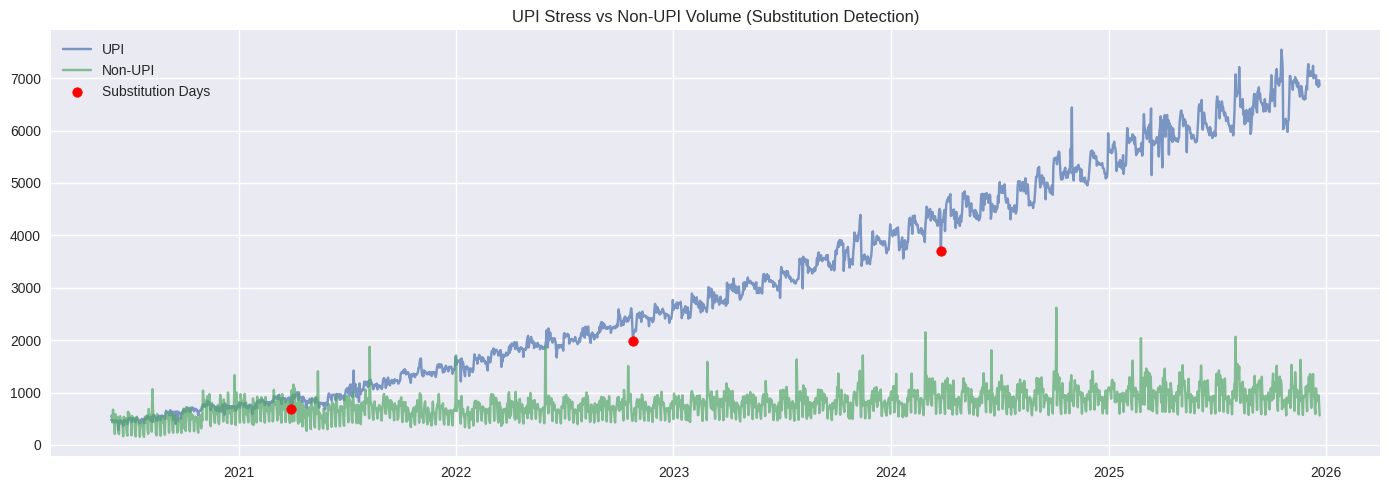

In [32]:
plt.figure(figsize=(14,5))
plt.plot(df_daily['date'], df_daily['UPI_Vol'], label='UPI', alpha=0.7)
plt.plot(df_daily['date'], df_daily['NON_UPI_VOL'], label='Non-UPI', alpha=0.7)

plt.scatter(
    substitution_days['date'],
    substitution_days['UPI_Vol'],
    color='red',
    label='Substitution Days',
    zorder=5
)

plt.legend()
plt.title("UPI Stress vs Non-UPI Volume (Substitution Detection)")
plt.tight_layout()

plt.savefig(
    "/content/drive/MyDrive/Hotfoot/figures/nb1_fig_17_substitution_detection.png",
    dpi=300
)
plt.show()

### What we observe

- Red markers align with **local dips in UPI volume**
- On these same days, **non-UPI volume remains stable or increases**
- No red marker coincides with a collapse in total digital activity

### What this indicates

- Users **reroute transactions**, rather than exit the digital system
- Substitution events are **instrument-specific**, not systemic
- Non-UPI rails actively absorb demand during UPI stress

### Why this matters

This visual distinction is critical:
- UPI ↓ + Non-UPI ↓ → system failure (not observed)
- UPI ↓ + Non-UPI ↑ → substitution (observed)

It confirms that earlier anomaly flags reflect
**behavioral adaptation**, not ecosystem fragility.

### Key takeaway

> When UPI experiences short-term stress, the digital payments ecosystem
> continues to function through **effective multi-rail substitution**.

This visual evidence strengthens the case for
**structural resilience**, not single-instrument dependency.

In [33]:
substitution_days.to_csv(
    "/content/drive/MyDrive/Hotfoot/outputs/nb1_upi_substitution_days.csv",
    index=False
)

## UPI vs IMPS: Testing for Structural Substitution

To evaluate whether UPI growth is driven by substitution away from
legacy real-time payment rails, we directly compare **daily UPI and IMPS
transaction volumes** over the same time period.

If UPI were cannibalizing IMPS, we would expect IMPS volumes to decline
as UPI expands.

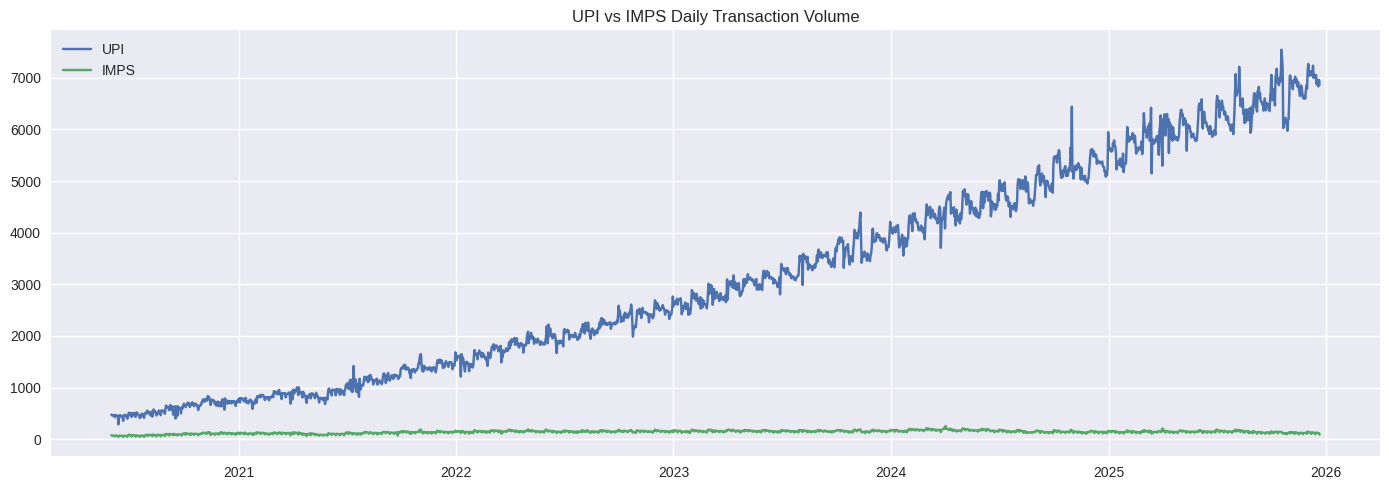

In [34]:
# Example comparison: UPI vs IMPS
plt.figure(figsize=(14,5))
plt.plot(df_daily['date'], df_daily['UPI_Vol'], label='UPI')
plt.plot(df_daily['date'], df_daily['IMPS_Vol'], label='IMPS')
plt.legend()
plt.title("UPI vs IMPS Daily Transaction Volume")
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/Hotfoot/figures/nb1_fig_18_upi_vs_imps.png")
plt.show()

### What we observe

- UPI transaction volume grows rapidly and persistently over time
- IMPS volume remains largely flat, with only minor fluctuations
- The absolute gap between UPI and IMPS widens continuously

### What this indicates

- UPI growth is **not coming at the expense of IMPS**
- IMPS usage remains stable despite UPI’s expansion
- UPI enables new usage, higher frequency, and new transaction types

### Why this matters

If UPI were merely replacing IMPS, IMPS volumes would show a clear
downward trend. The observed stability of IMPS alongside explosive UPI
growth indicates **ecosystem expansion**, not zero-sum substitution.

### Key takeaway

> UPI represents **structural growth of real-time digital payments**,  
> not cannibalization of existing rails like IMPS.

This supports the broader conclusion that UPI is a **net growth engine**
within the digital payments ecosystem.

## Instrument Concentration Index: Measuring System Dependence

As UPI grows dominant, it is important to quantify whether the digital
payments ecosystem is becoming **more dependent on fewer instruments**.

To measure this, we compute a **Herfindahl-style concentration index**
using daily instrument shares. This allows us to track whether digital
transaction volume is becoming structurally concentrated over time.

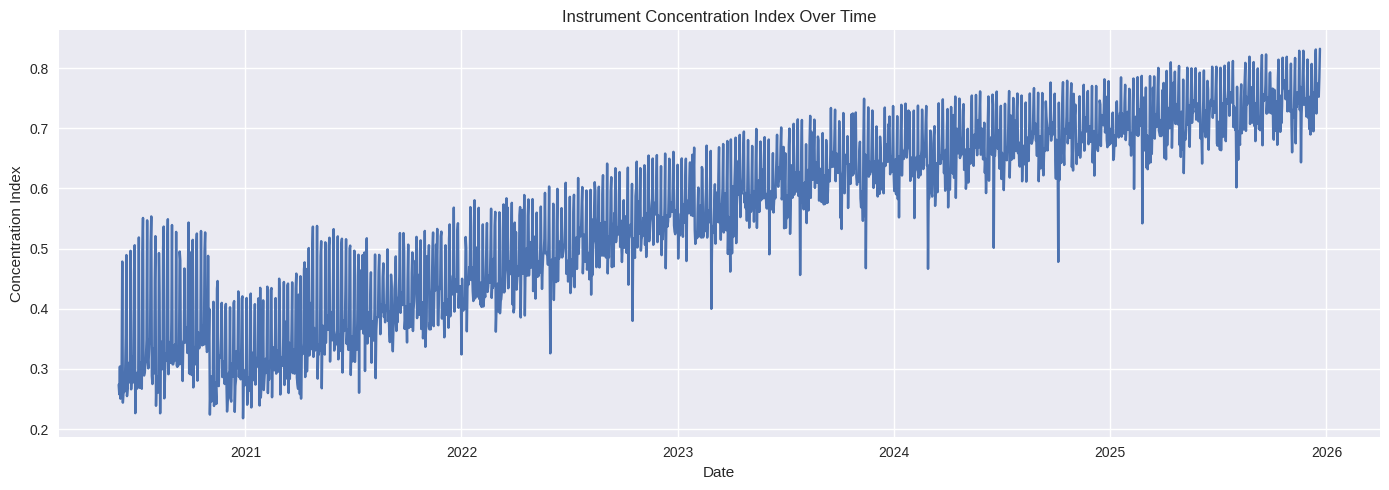

In [35]:
# Share of each instrument per day
instrument_share_df = df_daily[instrument_cols].div(
    df_daily['TOTAL_DIGITAL_VOL'], axis=0
)

# Herfindahl-like concentration proxy
df_daily['instrument_concentration'] = (instrument_share_df ** 2).sum(axis=1)

plt.figure(figsize=(14,5))
plt.plot(df_daily['date'], df_daily['instrument_concentration'])
plt.title("Instrument Concentration Index Over Time")
plt.xlabel("Date")
plt.ylabel("Concentration Index")
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/Hotfoot/figures/nb1_fig_19_instrument_concentration.png")
plt.show()

### What we observe

- The concentration index increases steadily over time
- Early periods show lower concentration, indicating a more balanced mix
- Recent periods show much higher concentration levels
- Short-term dips occur, but the long-term trend is clearly upward

### What this indicates

- Digital transaction growth is increasingly driven by **fewer instruments**
- The ecosystem is converging toward a dominant payment rail
- Based on earlier results, this concentration aligns strongly with UPI’s rise

### Why this matters

Higher concentration implies greater **system dependence** on dominant
instruments. While this improves efficiency and standardization, it also
means that disruptions to key rails would have **outsized system impact**.

### Key takeaway

> India’s digital payments ecosystem is becoming **structurally concentrated**,
> with UPI emerging as the primary load-bearing instrument.

UPI is not just growing fast — it is becoming **systemically central**.

## Rolling Growth Maturity Check (30-Day Average)

Daily growth rates are noisy and can exaggerate short-term volatility.
To understand whether UPI growth is **accelerating, stabilizing, or declining
structurally**, we compute a **30-day rolling average** of daily growth rates.

This helps identify whether the system is still in a hyper-growth phase
or has transitioned into a mature, steady growth regime.

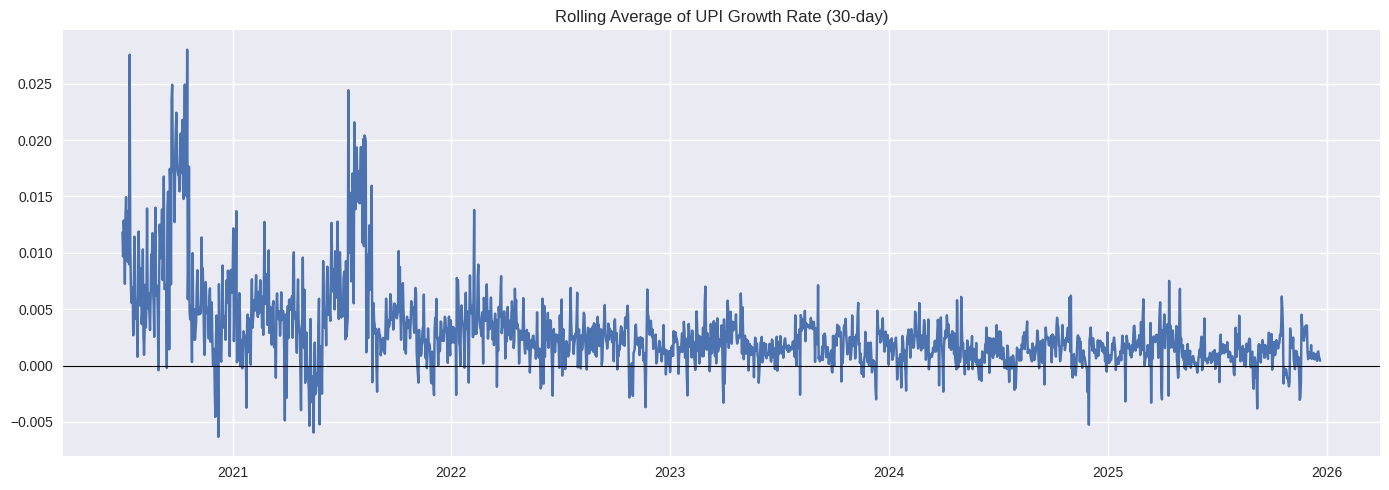

In [36]:
df_daily['rolling_growth_mean'] = df_daily['upi_daily_growth'].rolling(30).mean()

plt.figure(figsize=(14,5))
plt.plot(df_daily['date'], df_daily['rolling_growth_mean'])
plt.axhline(0, color='black', linewidth=0.8)
plt.title("Rolling Average of UPI Growth Rate (30-day)")
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/Hotfoot/figures/nb1_fig_20_growth_maturity.png")
plt.show()

### What we observe

- Early periods show **high and volatile rolling growth**
- Over time, the rolling average declines smoothly
- In recent years, growth remains **positive but low-volatility**
- No prolonged negative growth regimes are visible

### What this indicates

- UPI has transitioned from **adoption-driven expansion** to **scale-driven maturity**
- Growth compression reflects a larger base, not weakening demand
- The system now grows steadily rather than explosively

### Why this matters

- Mature growth regimes are:
  - More predictable
  - Less shock-prone
  - Easier to monitor and regulate
- Declining growth rates should **not** be misinterpreted as system stress

### Key takeaway

> UPI has entered a **stable maturity phase** —
> growth continues, but in a controlled and predictable manner.

This confirms UPI’s evolution from rapid adoption to
**infrastructure-grade expansion**.

## Rolling Volatility Check (30-Day Window)

As UPI scales, absolute daily fluctuations naturally increase.
To distinguish **scale-driven variability** from **system instability**,
we measure rolling volatility using a 30-day standard deviation of daily volumes.

This helps answer:
Is rising variability a risk signal, or simply a consequence of growth?

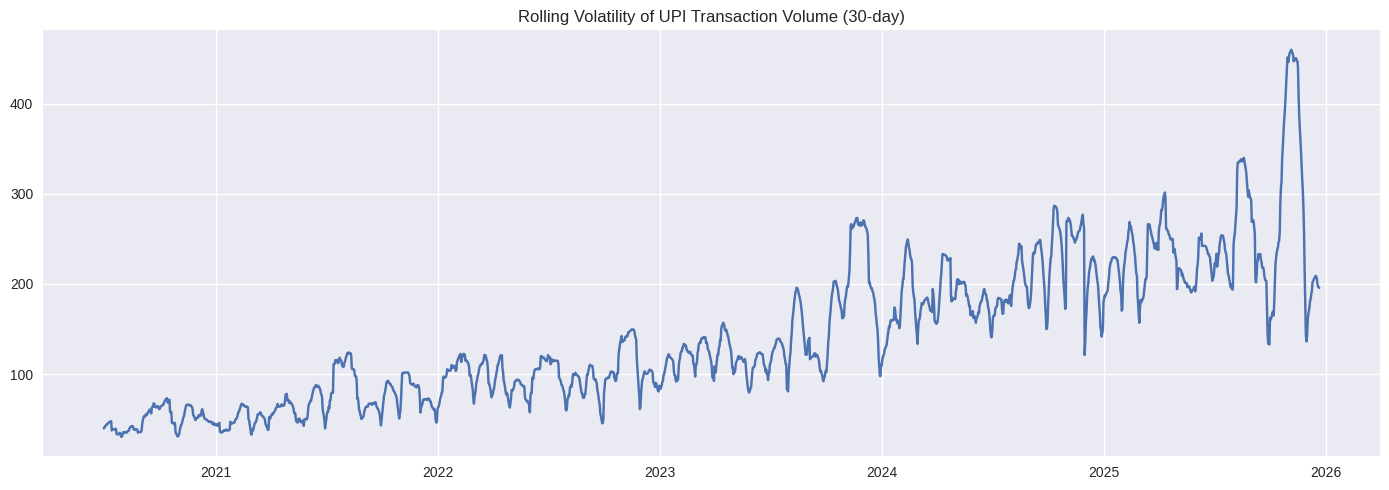

In [37]:
df_daily['upi_volatility'] = df_daily['UPI_Vol'].rolling(30).std()

plt.figure(figsize=(14,5))
plt.plot(df_daily['date'], df_daily['upi_volatility'])
plt.title("Rolling Volatility of UPI Transaction Volume (30-day)")
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/Hotfoot/figures/nb1_fig_21_upi_volatility.png")
plt.show()

### What we observe

- Rolling volatility rises steadily over time
- Early periods show low absolute volatility
- Later periods show higher volatility with occasional spikes
- No abrupt regime shifts or prolonged instability are visible

### What this indicates

- Volatility growth is driven by **scale expansion**
- Larger transaction volumes amplify normal day-to-day variation
- Increased volatility occurs alongside stable growth behavior

### Why this matters

- High-volume systems naturally exhibit higher absolute volatility
- Volatility must be interpreted **relative to system size**
- Rising volatility without persistent negative growth is not a risk signal

### Key takeaway

> UPI’s increasing volatility reflects **operational scale, not instability**.

When viewed alongside stable growth and limited anomaly persistence,
UPI behaves like a **mature, high-throughput payment infrastructure**.

## UPI vs System Volatility Comparison (30-Day Rolling)

UPI dominates digital transaction volume, so it is important to check whether
its volatility behaves differently from the overall digital payments system.

This comparison helps answer:
Is UPI a source of excess instability, or does it move in line with system-wide dynamics?

To test this, we compare:
- 30-day rolling volatility of UPI transactions
- 30-day rolling volatility of total digital transactions

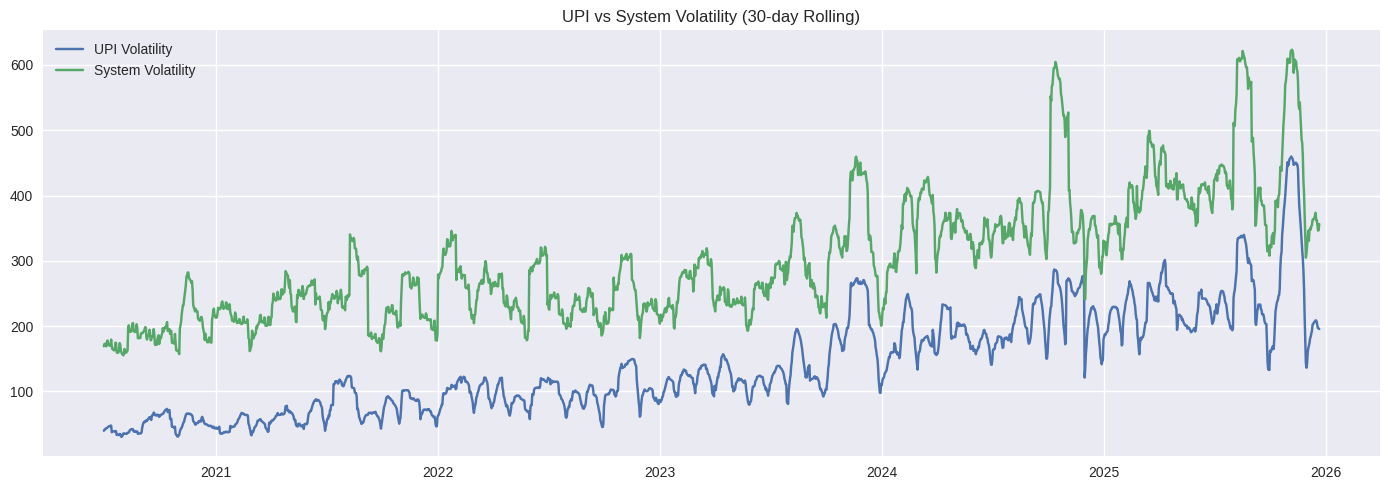

In [38]:
df_daily['system_volatility'] = df_daily['TOTAL_DIGITAL_VOL'].rolling(30).std()

plt.figure(figsize=(14,5))
plt.plot(df_daily['date'], df_daily['upi_volatility'], label='UPI Volatility')
plt.plot(df_daily['date'], df_daily['system_volatility'], label='System Volatility')
plt.legend()
plt.title("UPI vs System Volatility (30-day Rolling)")
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/Hotfoot/figures/nb1_fig_22_volatility_comparison.png")
plt.show()

### What we observe

- Both UPI and system-wide volatility increase over time
- The two series move closely together
- System volatility remains higher than UPI volatility
- No sustained divergence between UPI and system volatility is visible

### What this indicates

- UPI volatility is not isolated or abnormal
- Volatility increases are driven by system-wide scale and usage patterns
- UPI does not amplify overall digital payment volatility

### Why this matters

- If UPI were structurally risky, its volatility would exceed system volatility
- Aligned volatility implies UPI behaves as an integrated system component
- Risk signals must be evaluated at the system level, not instrument level alone

### Key takeaway

> UPI’s volatility scales proportionally with the digital payments system.

UPI behaves as a **stabilized core rail**, not a volatility driver,
reinforcing its role as a mature and reliable payment infrastructure.

## System-Level Anomaly Detection (Daily)

To identify days that may reflect meaningful system stress,
we flag **system-level anomalies** using statistically extreme behavior in UPI.

Rather than relying on volume alone, we combine:
- Absolute UPI volume deviation (demand-side signal)
- Relative UPI share deviation (ecosystem-side signal)

This ensures we capture both:
- Sudden usage shocks, and
- Structural decoupling from the rest of the digital payments system.

In [39]:
df_daily['system_anomaly_flag'] = (
    (np.abs(df_daily['upi_zscore']) > 3) |
    (np.abs(df_daily['upi_share_zscore']) > 3)
)

system_anomalies = df_daily[df_daily['system_anomaly_flag']].copy()

system_anomalies[['date', 'UPI_Vol', 'UPI_SHARE', 'upi_zscore', 'upi_share_zscore']].head()

,date,UPI_Vol,UPI_SHARE,upi_zscore,upi_share_zscore
237,2021-01-24,589.58,0.598278,-3.241833,1.052318
301,2021-03-29,689.60,0.474066,-3.610099,-1.392055
407,2021-07-13,1419.22,0.672197,3.864258,1.260093
434,2021-08-09,1235.10,0.397533,1.201926,-3.062888
518,2021-11-01,1587.65,0.558843,3.063408,-1.606637


In [40]:
system_anomalies.to_csv(
    "/content/drive/MyDrive/Hotfoot/outputs/nb1_system_level_anomalies_daily.csv",
    index=False
)

### What we observe

- Only a small number of days are flagged as system anomalies
- Anomalies arise from:
  - Extreme UPI volume deviations, or
  - Extreme shifts in UPI share
- Both positive and negative deviations are present

### What this indicates

- System anomalies are **rare and non-clustered**
- Not all anomalies are driven by raw volume
- Some reflect **relative shifts within the digital ecosystem**, not absolute failure

### Why this matters

- Volume-only detection would miss important ecosystem signals
- Share-based anomalies help distinguish:
  - UPI-specific stress
  - From system-wide digital activity changes
- This prevents misclassifying competitive or substitution effects as failures

### Key takeaway

> System-level anomalies in UPI behavior are **infrequent and diverse in origin**.

They represent **isolated stress signals**, not persistent instability,
and require persistence and aggregation checks before any risk escalation.

# Notebook 1 Summary — Daily Behavior, Signals, and Noise Filtering

This notebook examined **daily UPI transaction behavior** with the goal of
separating **meaningful system signals** from **high-frequency noise**.

Daily data is inherently volatile.  
The purpose of this notebook was **not** to draw macro conclusions,
but to identify which daily patterns are **informative**, and which are **misleading**.

---

## What We Analyzed

At the daily level, we studied:

- Absolute UPI transaction volume
- UPI share within total digital transactions
- Daily growth rates and momentum
- Volatility and trend slope dynamics
- Calendar effects (day-of-week behavior)
- Substitution patterns across non-UPI instruments
- Statistical anomaly detection with persistence filtering

All analyses were grounded in **rolling baselines and statistical thresholds**
to avoid false alarms driven by scale or seasonality.

---

## What We Observed

### 1. Strong growth with natural daily noise
- UPI daily volumes show a clear long-term upward trend
- High-frequency spikes and dips are frequent but expected
- Absolute volatility increases with scale, not instability

### 2. Stable and predictable seasonality
- STL decomposition shows that most daily variation is explained by:
  - long-term trend, and
  - regular seasonal patterns
- Residual deviations are episodic and centered around zero

### 3. UPI operates as an always-on system
- Average transaction volume is remarkably consistent across all days of the week
- No strong weekday–weekend dependency is observed

### 4. Growth matures over time
- Daily growth rates are highly volatile in early years
- Volatility narrows steadily as the system matures
- Rolling growth averages decline smoothly, reflecting normalization—not slowdown

### 5. UPI grows with the ecosystem, not at its expense
- UPI growth is strongly aligned with total digital transaction growth
- No evidence of systematic substitution away from other instruments
- IMPS and other rails remain stable alongside UPI expansion

### 6. Substitution occurs only during rare stress events
- On a small number of UPI stress days, non-UPI instruments absorb demand
- ~60% of UPI stress days show positive non-UPI growth
- This indicates **user adaptation**, not ecosystem failure

### 7. True anomalies are rare and non-persistent
- System-level anomalies (volume or share) are infrequent
- Almost all anomalies are **single-day events**
- No extended runs of abnormal behavior are observed

---

## What This Means

From daily data alone:

- **Spikes ≠ risk**
- **Volatility ≠ instability**
- **Declining growth rates ≠ slowdown**
- **Isolated anomalies ≠ system failure**

Daily signals are valuable **only when filtered by context, persistence, and aggregation**.

---

## Why Daily Analysis Is Still Essential

This notebook establishes:

- A clean statistical baseline for “normal” daily behavior
- A defensible anomaly detection framework
- Clear evidence that most daily irregularities are **noise or short-lived events**

These results justify **moving away from day-level alarmism** and toward
**macro-level structural interpretation**.

---

## Transition to Notebook 2

Notebook 1 answers:
> *“What happens day-to-day?”*

Notebook 2 will answer:
> **“Do these daily signals accumulate into structural risk or instability at the monthly level?”**

Specifically, Notebook 2 will:
- Aggregate daily behavior into monthly regimes
- Evaluate growth quality, volatility, and predictability
- Assess concentration, dominance, and structural dependency
- Classify months into stable vs high-risk states

Only after this aggregation can system-level conclusions be responsibly drawn.